In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.plotting import view_img
import math
import os
from os.path import join, exists, split
from pathlib import Path
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
from bids.layout import BIDSLayout

In [2]:
datadir = Path('/tank/shared/2023/dist_supp_pRF/pilot_data/')
datadir_bids = Path(datadir, 'bids_data')
derivatives = 'derivatives'
datadir_fmriprep = Path(datadir, derivatives, 'fmriprep')
datadir_freesufer = Path(datadir, derivatives, 'freesurfer')
outputdir = Path(datadir, derivatives, 'GLMsingle_test', 'GLMsingle_8loc_lib', 'GLMsingle')

In [3]:
sub = '002'
ses = '01'
bg_run = 1

In [4]:
bids_layout = BIDSLayout(datadir_bids, validate=False)
fmriprep_layout = BIDSLayout(datadir_fmriprep, validate=False)

## Load design information

In [5]:
DESIGNINFO = np.load(Path(outputdir,'DESIGNINFO.npy'),allow_pickle=True).item()

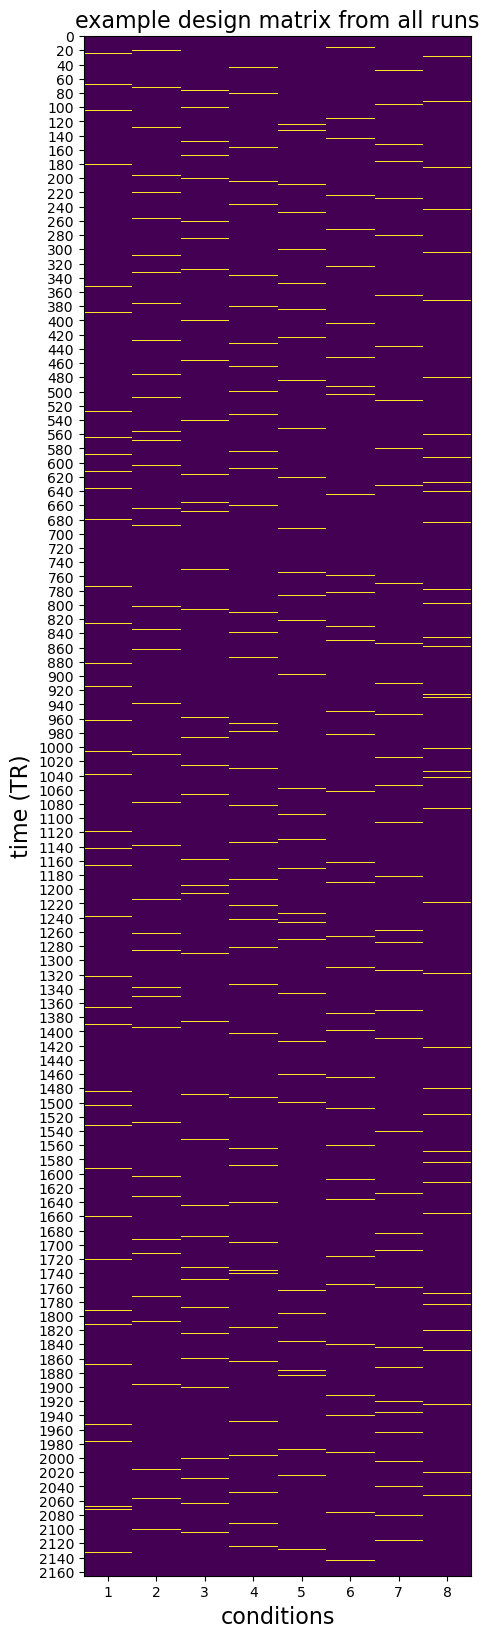

In [6]:
stim_con_dms = np.concatenate(DESIGNINFO['design'])
plt.figure(figsize=(5,20))
ax = plt.gca()
plt.title('example design matrix from all runs',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16)
xticks = [*range(0,stim_con_dms.shape[1]+1, 1)]
xticklabels = [*range(1,stim_con_dms.shape[1]+2, 1)]
yticks = [*range(0,stim_con_dms.shape[0], 20)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
plt.imshow(stim_con_dms, interpolation='none', aspect='auto');

In [7]:
tr_ind, angle_ind = np.where(stim_con_dms==1)
stim_onset = list(zip(tr_ind, angle_ind))

## Load background image

In [8]:
bg_image_fn = fmriprep_layout.get(subject=sub, 
                                  session=ses, 
                                  task='ping', 
                                  run=bg_run, 
                                  space='T1w',
                                  suffix="boldref",
                                  extension='nii.gz')[0]
bref = nib.load(bg_image_fn)

bmask_fn = fmriprep_layout.get(subject=sub,
                                 session=ses,
                                 task='ping',
                                 run=bg_run,
                                 space='T1w',
                                 suffix='mask',
                                 extension='nii.gz')[0]
bmask = nib.load(bmask_fn)

## Load typeA ONOFF R2

/tank/nwa201/anaconda3/envs/suppr_pRF/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



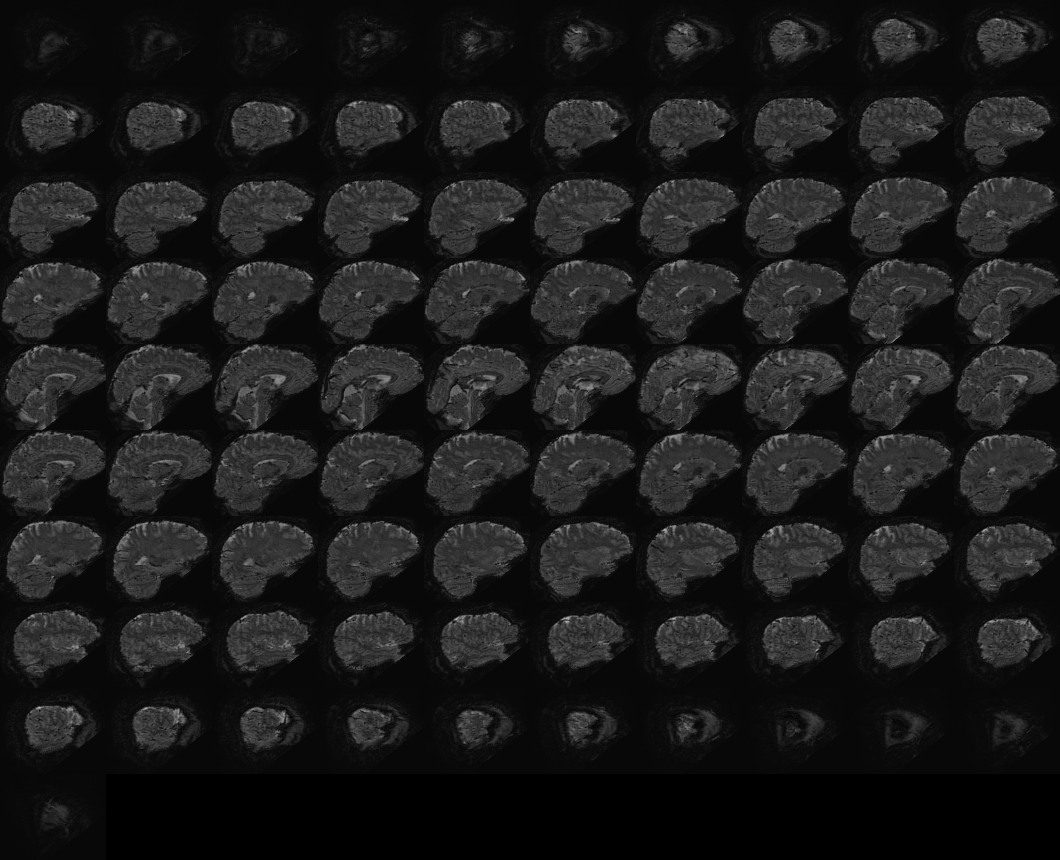
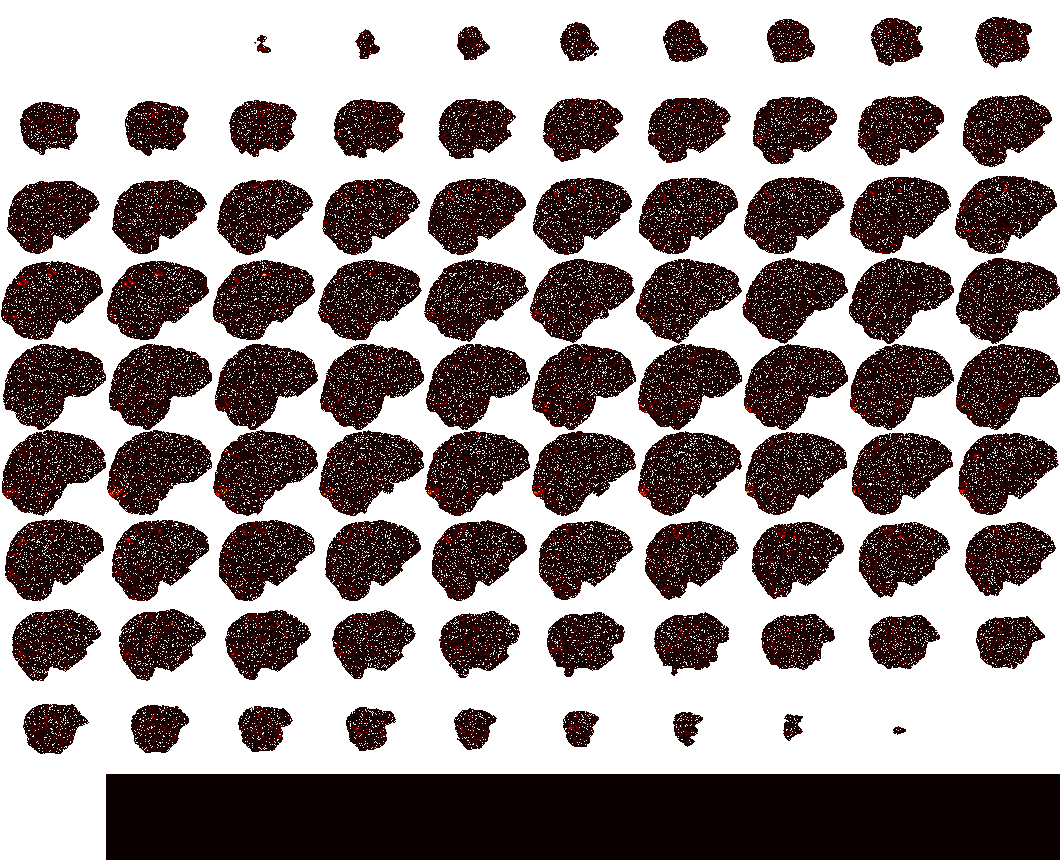

In [9]:
view_img(Path(outputdir,'TYPEA_onoffR2.nii.gz'),
         threshold='60%',
         cmap='hot', 
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)

## Load typeC R2

/tank/nwa201/anaconda3/envs/suppr_pRF/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/tank/nwa201/anaconda3/envs/suppr_pRF/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')



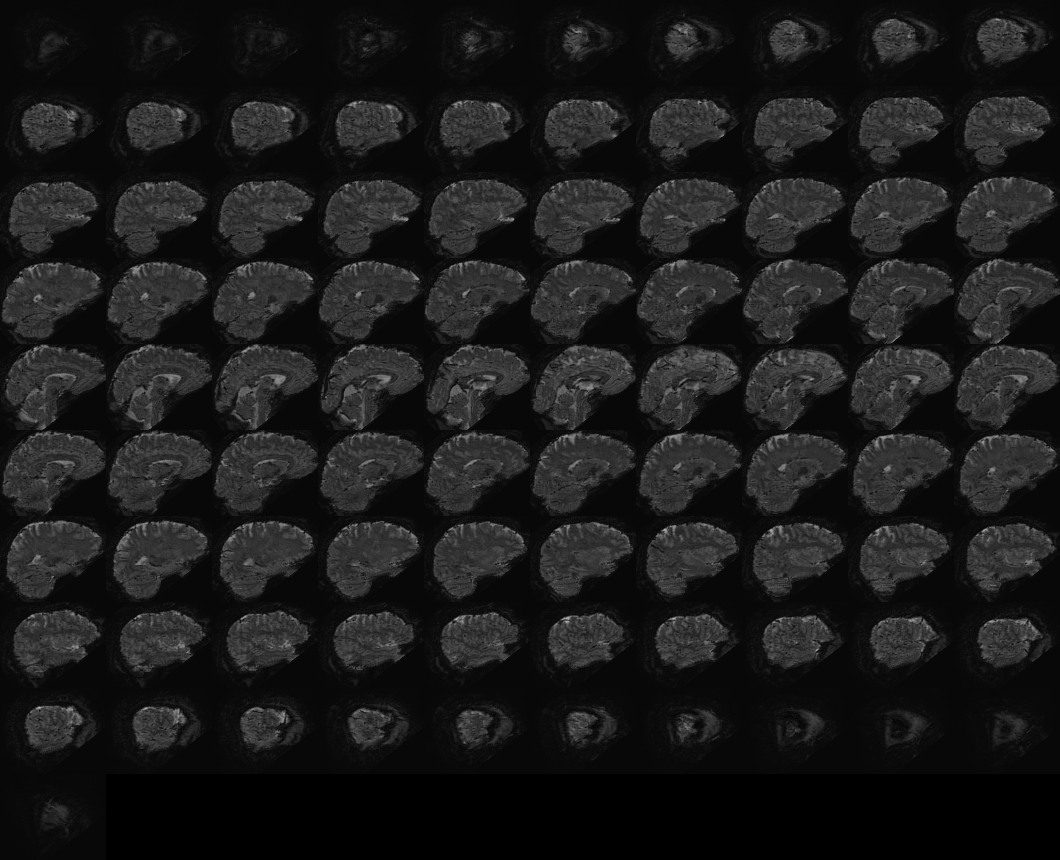
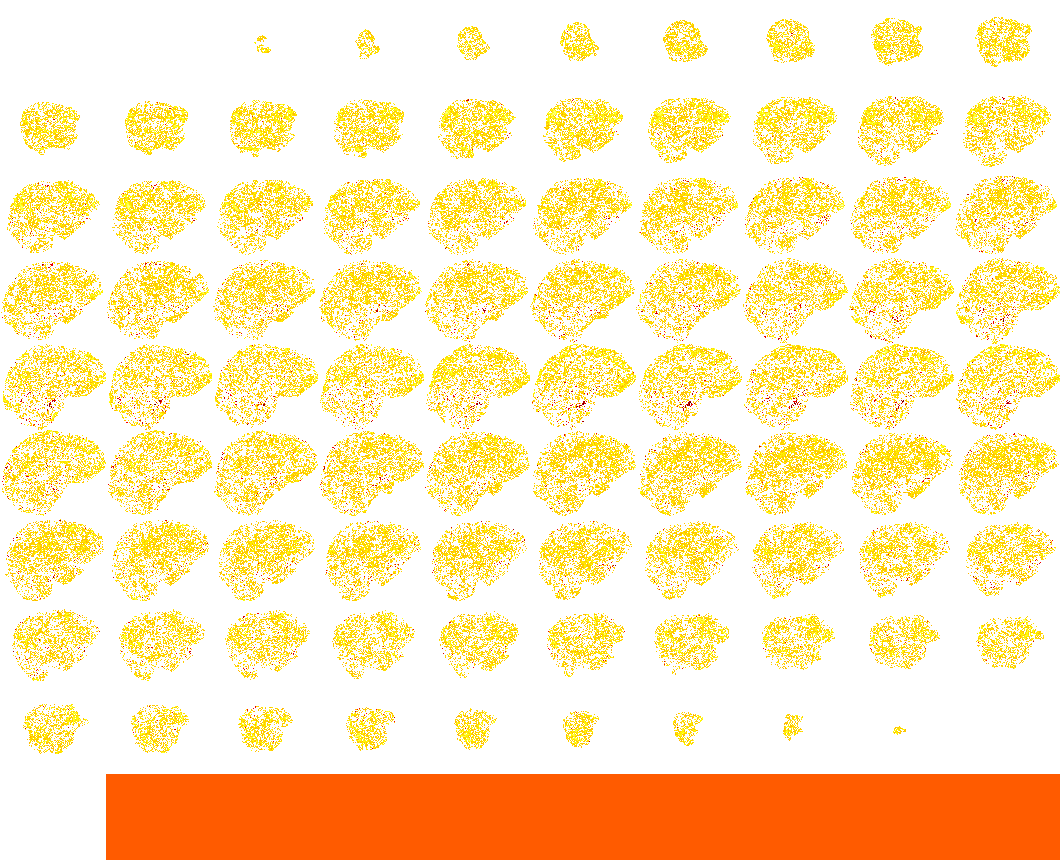

In [10]:
view_img(Path(outputdir,'TYPEC_R2.nii.gz'),
         threshold='80%',
         cmap='hot', 
         vmin=0.,
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)

## Load typeD R2


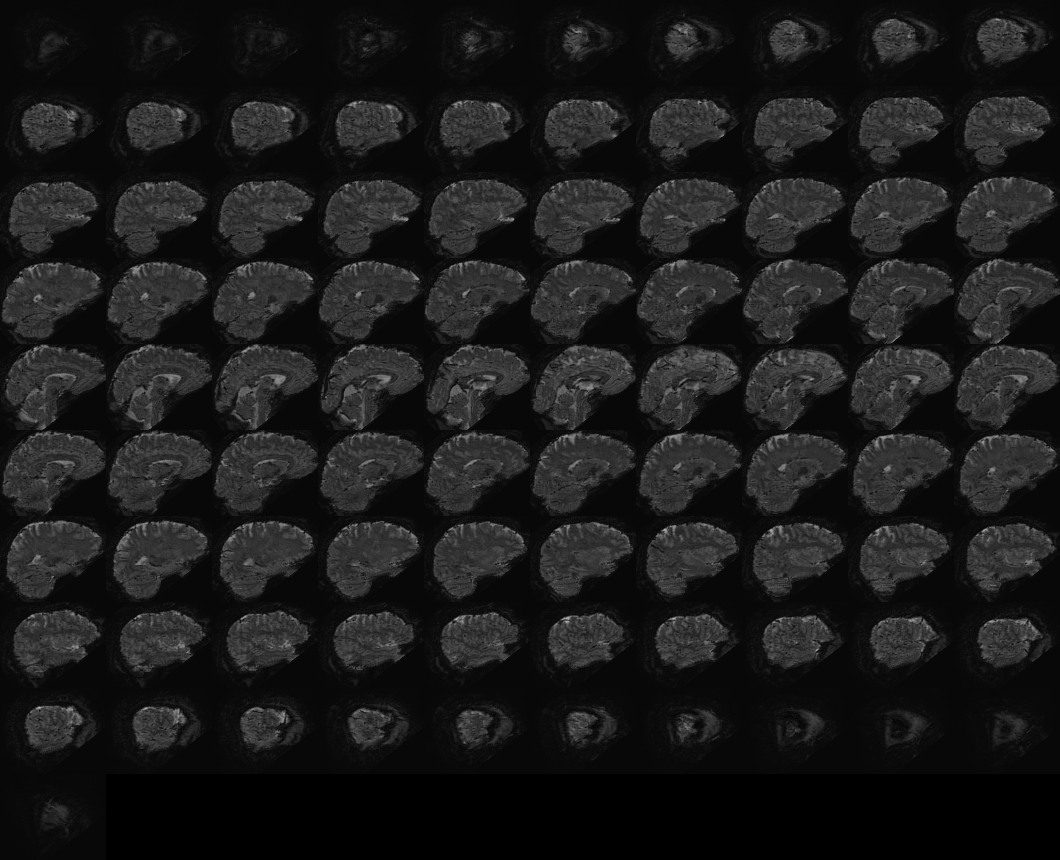
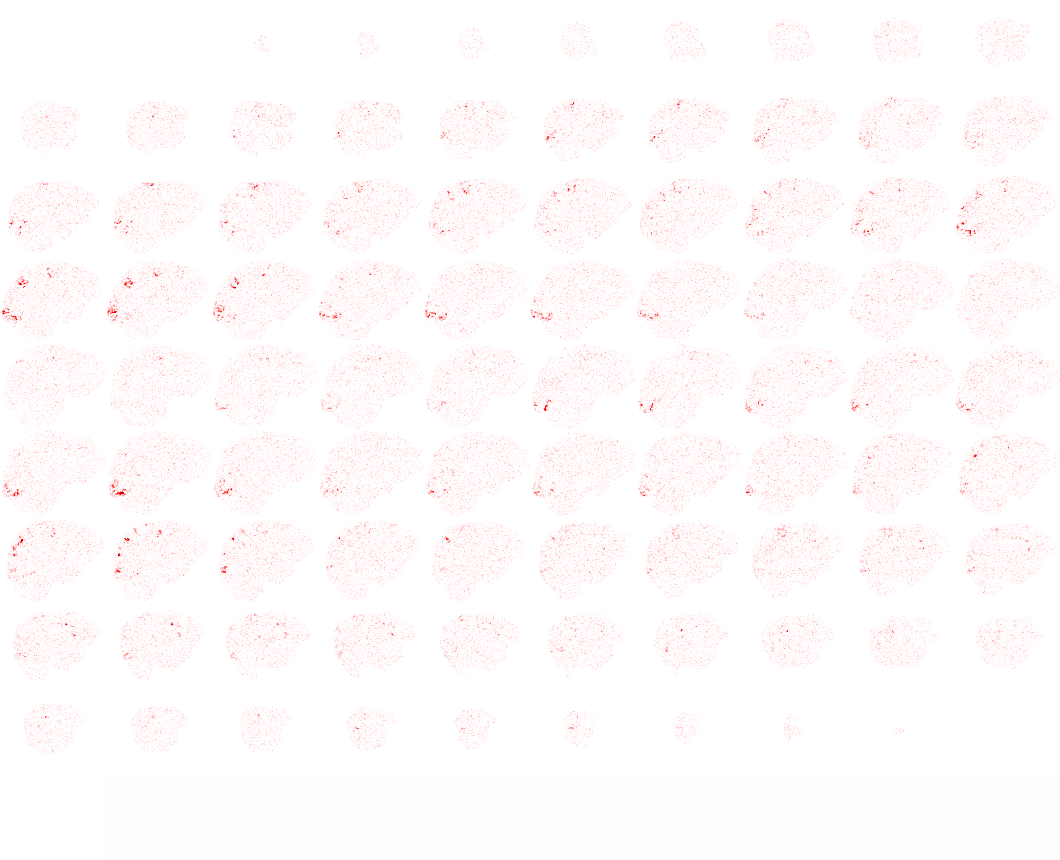

In [11]:
TYPED_R2 = nib.load(Path(outputdir,'TYPED_R2.nii.gz'))
view_img(TYPED_R2,
         # threshold='80%',
         cmap='seismic', 
         # vmin=0,
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)


## Load typeD fractal value


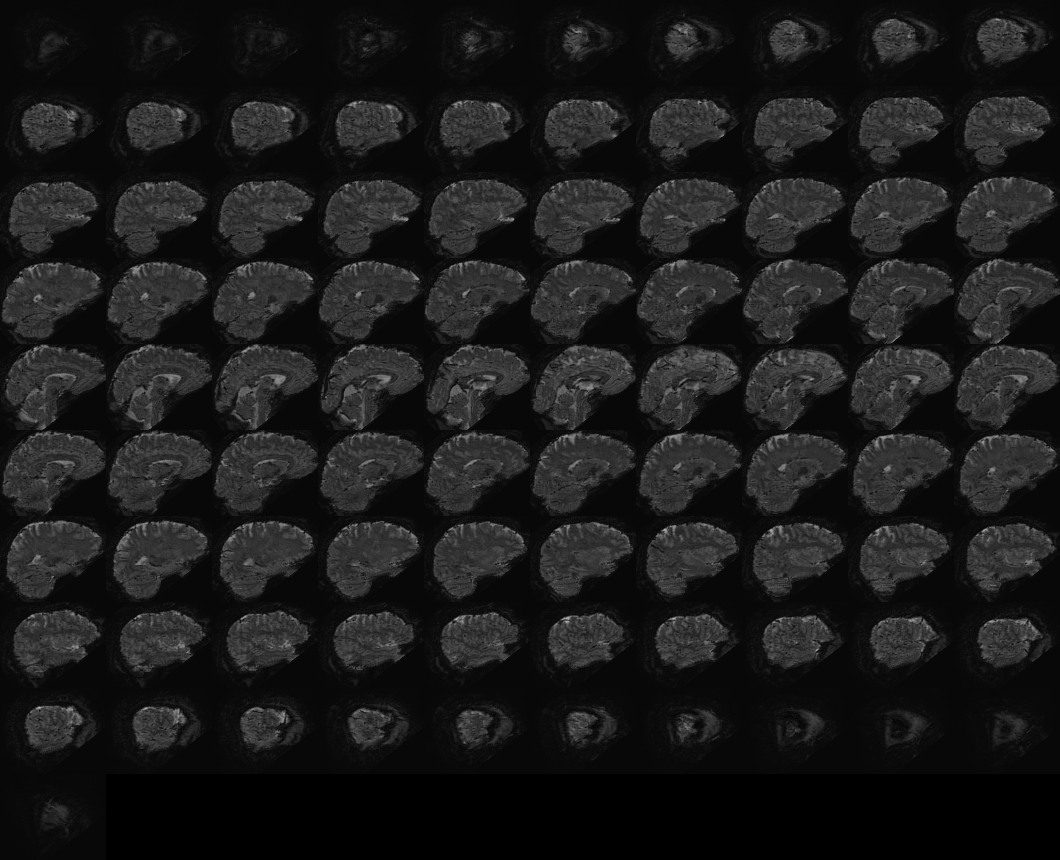
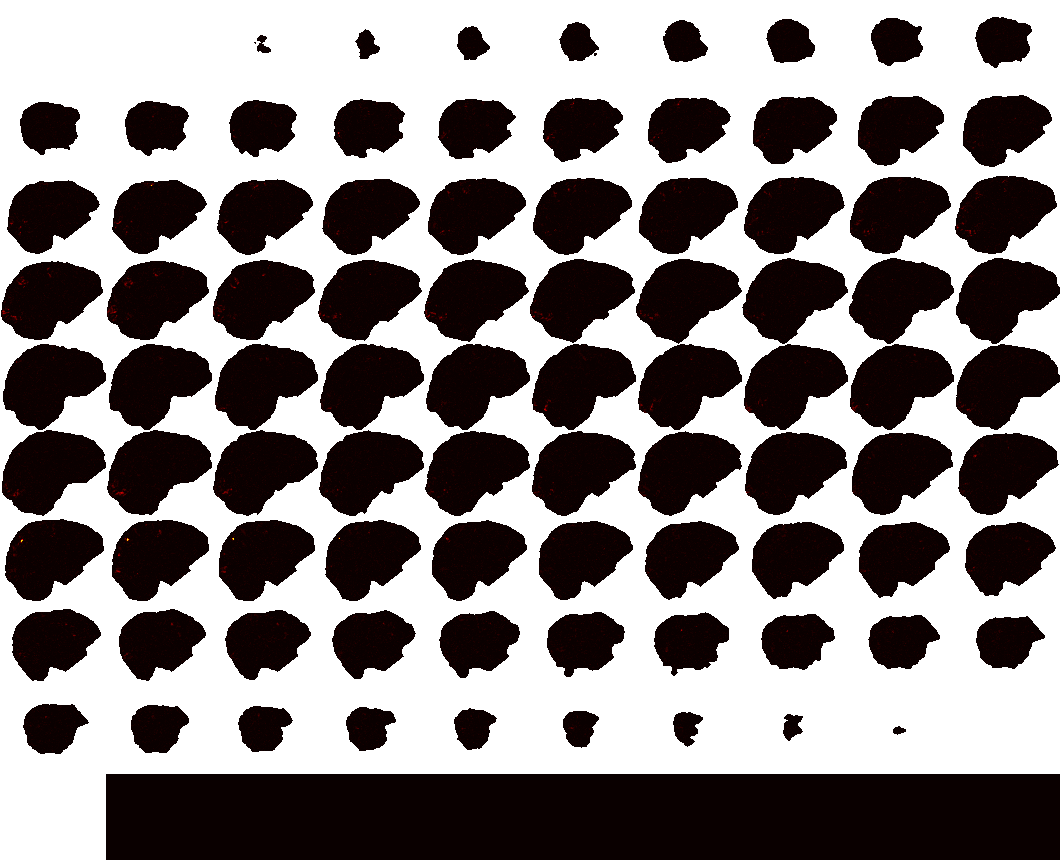

In [12]:
view_img(Path(outputdir,'TYPED_FRACvalue.nii.gz'),
         # threshold='80%',
         cmap='hot', 
         # vmin=0,
         vmax=1,
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)

## Display thresholded Retinamap

In [13]:
R2_percentile = 85

TYPED_retinamap = nib.load(Path(outputdir,'TYPED_retinamap.nii.gz'))

# set threshold
TYPED_R2_data = TYPED_R2.get_fdata()
TYPED_R2_data[bmask.get_fdata()<1] = np.nan
q = np.nanpercentile(TYPED_R2_data, R2_percentile)
TYPED_R2_data[TYPED_R2_data<q] = np.nan
TYPED_retinamap_data = TYPED_retinamap.get_fdata()
TYPED_retinamap_data[np.isnan(TYPED_R2_data)] = np.nan 
TYPED_retinamap_thred = nib.Nifti1Image(TYPED_retinamap_data, TYPED_retinamap.affine, TYPED_retinamap.header)
TYPED_R2_thred = nib.Nifti1Image(TYPED_R2_data, TYPED_R2.affine, TYPED_R2.header)

In [14]:
print(f"The range of the thresholded R2 is from {np.nanmin(TYPED_R2_data):.2f} to {np.nanmax(TYPED_R2_data):.2f}")

The range of the thresholded R2 is from 0.85 to 24.00


/tank/nwa201/anaconda3/envs/suppr_pRF/lib/python3.10/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



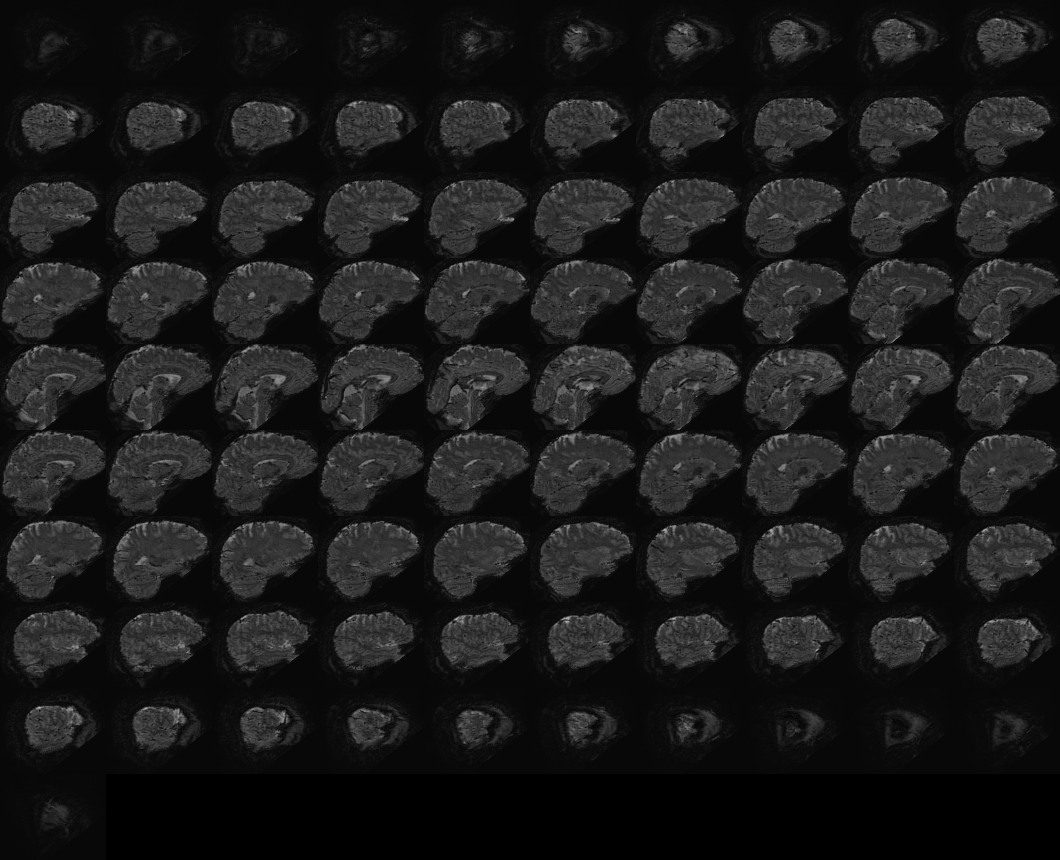
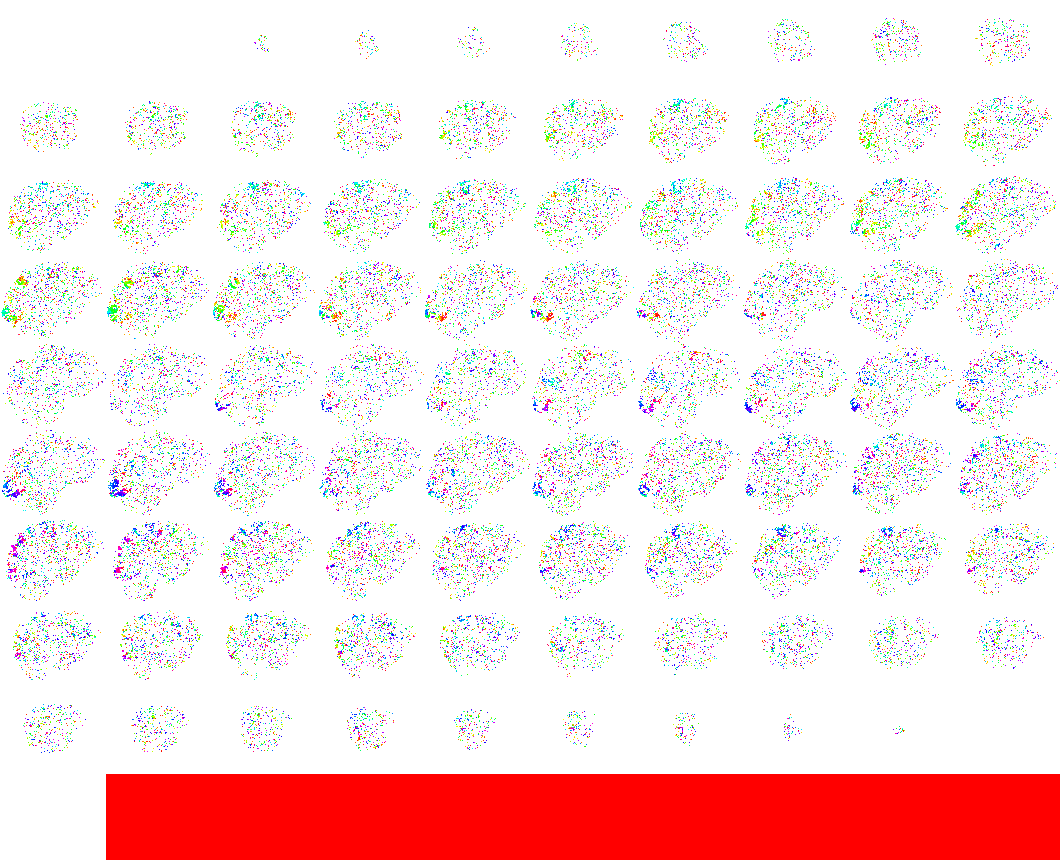

In [15]:
view_img(TYPED_retinamap_thred,
         cmap='hsv', 
         symmetric_cmap=False, 
         bg_img=bg_image_fn,)